# Chemical potential


**Code:** #132-000

**File:** `apps/fermi_gas/chemical_potential.ipynb
`
**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Ikergym/MinervaLab/master?filepath=apps%2Ffermi_gas%2Fchemical_potential.ipynb)

-----------

The aim os this notebook is to help visualize the temperature dependence of the chemical potential for electrons using the Fermi-Dirac distribution.

## Interface

The main interface (``main_block_132_000``) is divided two blocks: ``left_block_132_000`` and ``center_block_132_000``. 

``left_block_132_000`` contains the widgets to control the figures: ``metal_dropdown``, ``fermi_energy_text``, ``fermi_temp_text``, ``T_slider``, ``mu_text_absolute``, ``mu_text_relative``, ``show_trace_check`` and ``show_legend_check``.

``center_block_132_000`` contains two bqplot figures: ``fig_132_001`` and ``fig_132_002``.

``right_block_124_000`` contains the output widgets related to the energy: ``Qh_text``, ``Qc_text``, ``W_text``, and ``eta_text``.

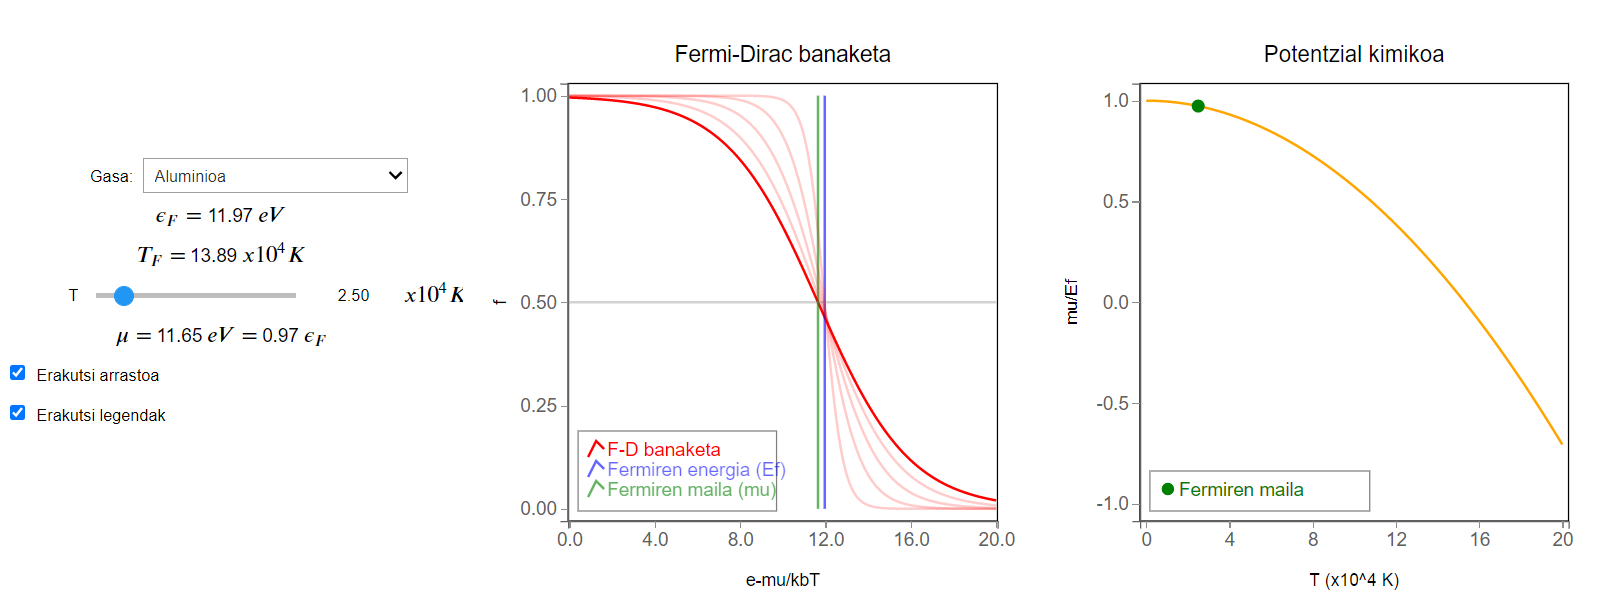

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [1]:
from IPython.display import Image
Image(filename='../../static/images/apps/fermi_gas/132-000.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [ ]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [ ]:
import numpy as np

from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

## Physical functions

This are the functions that have a physical meaning:
- `get_n`
- `get_Ef`
- `get_mu`
- `get_FD`

In [ ]:
def get_n(z, dens, mass_mol):
    '''
    This functions calculates the electron density for a
    given metal
    
    Inputs:
    z: integer for number of valence electrons
    dens: float for density of metal in kg/m**3
    mass_mol: float for molar mass in kg
    
    Returns:
    n: float for electron density in m**-3
    '''
    
    n = z*Na * dens/mass_mol
    return n

In [ ]:
def get_Ef(n):
    '''
    This function calculates the Fermi energy (in eV) for
    a given metal with electron density n.
    
    Inputs:
    n: float for electron density in m**-3
    
    Returns:
    Ef: float for Fermi energy in eV
    '''
    
    Ef = h**2/(2*me)*(3*pi**2*n)**(2.0/3.0)
    return Ef

In [ ]:
def get_mu(Ef,T):
    '''
    This function calculates the Fermi Level (chemical potential) for
    a metal characterized by Fermi energy Ef at temperature T. This
    calculations is done by applying second order Sommerfeld expansion.
    
    Inputs:
    Ef: float for Fermi energy in eV
    T: float for temperature in 10^4*K
    
    Returns:
    mu: float for Fermi level in eV
    '''
    
    mu = Ef*(1.0-1.0/3.0*(pi*kb*T/2.0/Ef)**2)
    return mu

In [ ]:
def get_FD(Ef, T, mu):
    '''
    This function calculates the F-D distribution values for a 
    metal with Ef and in temperature T, for which mu(T) is already
    calculated.
    
    Inputs:
    Ef: float value for fermi energy (in eV)
    T: float value for temperature (in 10**4 K)
    mu: float value for chemical potential (in eV)
    
    Returns:
    y_values: a 1darray of float values for F-D distribution
    '''
    
    y_values = np.empty(pts)
    overflow = False  # Flag to control overflow with very little exponents
    for i in range(pts):
        if overflow == False:
            E = E_values[i]
            y_values[i] = 1.0/(np.exp((E-mu)/kb/T)+1.0)
            if y_values[i] < 1.0e-20:  # Exponents smaller than -20 considered 0
                overflow = True
        else:
            y_values[i] = 0.0
    
    return y_values

## Functions related to the interaction

In [ ]:
def show_legend(change):
    '''
    This function controles the visibility of the
    legend of both figures depending on the value of
    the checkbox widget.
    '''
    
    # Read widgets
    show_legend_value = show_legend_check.value
    
    # Update visibility
    FermiDirac_001.display_legend=show_legend_value
    FermiEnergy_001.display_legend=show_legend_value
    ChemicalValue_001.display_legend=show_legend_value
    ChemicalMark_002.display_legend=show_legend_value

In [ ]:
def show_trace(change):
    '''
    This function controles the visibility of the 
    trace curve depending on the value of the checkbox
    widget.
    '''
    
    # Read widgets
    show_trace_value = show_trace_check.value
    
    # Update visibility
    FermiTrace_001.visible = show_trace_value

In [ ]:
def update_trace(y_old):
    '''
    This function updates the trace of the F-D distribution
    curves, whenever the temperature changes
    
    Inputs:
    y_old: 1d array of the y_values of last f-d curve
    (other values are read from widgets)
    '''
    
    y_trace = FermiTrace_001.y
    n_trace = 4
    
    # Update trace
    if y_trace.size == 0:  # Case: trace is empty
        y_trace = np.array(y_old)
        FermiTrace_001.y = y_trace
        
    elif y_trace.size == pts:  # Case: trace has only 1 curve
        y_trace = np.array([y_trace])
        y_trace = np.append(y_trace,[y_old],0)
        FermiTrace_001.y = y_trace
        
    elif y_trace.shape[0] == n_trace:  # Case: trace has max num. of curves
        for i in range(n_trace-1):
            y_trace[i] = y_trace[i+1]
        y_trace[n_trace-1] = y_old

        FermiTrace_001.y = []  # Needed to reset trace functions. Otherwise crashes
        FermiTrace_001.y = y_trace
        
    else:  # General case
        y_trace = np.append(y_trace, [y_old],0)
        FermiTrace_001.y = y_trace

In [ ]:
def update_temp(change):
    '''
    This function updates the temperature-dependent marks
    when temperature (or metal) is changed.
    '''
    
    # Read widgets
    T = T_slider.value
    Ef = float(fermi_energy_text.value)
    y_old = FermiDirac_001.y
    y_trace = FermiTrace_001.y
    
    # Calculate mu
    mu = get_mu(Ef,T)

    # Calculate F-D distribution
    y_values = get_FD(Ef, T, mu)

    # Update curves
    FermiDirac_001.y = y_values  
    ChemicalValue_001.x = np.full(2, mu)
    ChemicalMark_002.x = [T]
    ChemicalMark_002.y = [mu/Ef]

    # Update trace
    update_trace(y_old)
        
    # Update output widgets
    mu_text_absolute.value = '%.2f' % mu
    mu_text_relative.value = '%.2f' % (mu/Ef)

In [ ]:
def update_metal(change):
    '''
    This functions updates both figures when
    the current metal is changed.
    '''
    
    # Read widgets
    metal = metal_dropdown.value
    
    # Calculate Ef and Tf
    rho = metal_densities[metal]
    mass = molar_masses[metal]
    z = valence_numbers[metal]  
    n = get_n(z, rho, mass)
    Ef = get_Ef(n)
    Tf = Ef/kb
    
    # Get Chemical Potential curve
    mu_values = np.empty(pts)
    for i in range(pts):
        mu_values[i] = get_mu(Ef, T_values[i])
    
    # Update curves
    FermiEnergy_001.x = np.full(2, Ef)
    ChemicalCurve_002.y = mu_values/Ef
    
    # Update output widgets
    fermi_energy_text.value = '%.2f' % Ef
    fermi_temp_text.value = '%.2f' % Tf
    
    # Update figure legend location
    if metal == 0:
        fig_132_001.legend_location = 'top-right'
        fig_132_002.legend_location = 'top-right'
    else:
        fig_132_001.legend_location = 'bottom-left'
        fig_132_002.legend_location = 'bottom-left'
    
    # Update temperature dependent parameters
    update_temp(None)
        
    # Reset Trace
    FermiTrace_001.y = []

## Main interface

In [ ]:
#######################
###   PARAMETERS    ###
#######################

# Universal constant (only used to get Ef)
h = 6.5821e-16 #Planck's reduced constant in eV*s
c = 3.0e8 # Speed of Light in m/s
me = 510998.9/c**2 # Electron mass in eV/c**2
Na = 6.0221e23
kb = 8.617e-1 # Boltzmann's in eV/(10**4 K).
pi =  np.pi

# Plot parameters (temperatures in 10**4 K)
pts = 5000 # Number of points to calculate
T_min = 0.001 # Minimun T value on slider
T_max = 20.0 # Maximun T value on slider

# Metal data:(data obtained from Wikipedia)
metal_labels = ["Sodioa", "Aluminioa", "Burdina", "Kobrea"] 
metal_densities = [968.0, 2700.0, 7874.0, 8960.0] # In kg/m**3
molar_masses = [0.0229, 0.026, 0.0558, 0.0635] # In Kg
valence_numbers = [1, 3, 2, 1]

# Initial values
T = 2.0  # Initial T value
metal = 1 # Initial metal index {0: 'Na', 1: 'Al', 2: 'Fe', 3: 'Cu'}

# Figures xRanges
E_values = np.linspace(0.0,20.0,pts)
T_values = np.linspace(T_min, T_max, pts)


########################
###CREATE THE FIGURES###
########################

fig_132_001 = bq.Figure(title='Fermi-Dirac banaketa',
                marks=[],
                axes=[],
                animation_duration=0,
                legend_location='bottom-left',
                legend_style= {'fill': 'white', 'stroke': 'grey', 'width': '35%'},
                legend_text= {'font-size':'15px'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                layout = widgets.Layout(width='50%'),
                toolbar = True,
    )

fig_132_002 = bq.Figure(title='Potentzial kimikoa',
                marks=[],
                axes=[],
                animation_duration=0,
                legend_location='bottom-left',
                legend_text= {'font-size':15},
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                layout = widgets.Layout(width='50%'),
                toolbar = True,
    )

scale_x_001 = bqs.LinearScale(min = 0.0, max = 20.0)
scale_y_001 = bqs.LinearScale(min = 0.0, max = 1.0)
scale_x_002 = bqs.LinearScale(min = 0.0, max = T_max)
scale_y_002 = bqs.LinearScale(min = -1.0, max = 1.0)

axis_x_001 = bqa.Axis(
                scale=scale_x_001,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0.0, 20.0, 6),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='e-mu/kbT',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_001 = bqa.Axis(
                scale=scale_y_001,
                tick_format='.2f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0.0,1.0,5),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='f',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

axis_x_002 = bqa.Axis(
                scale=scale_x_002,
                tick_format='.0f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0.0, 20.0, 6),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='T (x10^4 K)',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_002 = bqa.Axis(
                scale=scale_y_002,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values=np.linspace(-1.0,1.0,5),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='mu/Ef',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_132_001.axes = [axis_x_001, axis_y_001]
fig_132_002.axes = [axis_x_002, axis_y_002]


########################
####CREATE THE MARKS####
########################


FermiDirac_001 = bqm.Lines(
                x = E_values, 
                y = np.empty(pts), 
                scales = {'x': scale_x_001, 'y': scale_y_001}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = ['red'],
                labels = ['F-D banaketa'],
                display_legend = True,
)

FermiEnergy_001 = bqm.Lines(
                x = np.empty(2),
                y = np.linspace(0.0,1.0,2),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.6],
                visible = True,
                colors = ['blue'],
                labels = ['Fermiren energia (Ef)'],
                display_legend = True,
                
)

ChemicalValue_001 = bqm.Lines(
                x = np.empty(2),
                y = np.linspace(0.0,1.0,2),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.6],
                visible = True,
                colors = ['green'],
                labels = ['Fermiren maila (mu)'],
                display_legend = True,
)

HalfGrid_001 = bqm.Lines(
                x = np.linspace(0.0,20.0,2),
                y = np.full(2,0.5),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.4],
                visible = True,
                colors = ['#8e8e8e'],
                display_legend = False,
)

FermiTrace_001 = bqm.Lines(
                x = E_values,
                y = [],
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.2],
                visible = True,
                colors = ['red'],
                display_legend = False,
)


ChemicalCurve_002 = bqm.Lines(
                x = T_values, 
                y = np.empty(pts), 
                scales = {'x': scale_x_002, 'y': scale_y_002}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = ['orange'],
                #labels = ['mu(T)'],
                display_legend = False
)

ChemicalMark_002 = bqm.Scatter(
                x = [], 
                y = [], 
                scales = {'x': scale_x_002, 'y': scale_y_002}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = ['green'],
                labels = ['Fermiren maila'],
                display_legend = True
)


fig_132_001.marks = [FermiDirac_001, FermiEnergy_001, ChemicalValue_001, HalfGrid_001, FermiTrace_001]
fig_132_002.marks = [ChemicalCurve_002, ChemicalMark_002]


########################
######  WIDGETS  #######
########################

## Input Widgets ##

T_slider = widgets.FloatSlider(
    min=T_min,
    max=T_max,
    step=0.5,
    value=T,
    description='T',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout = widgets.Layout(width='90%'),
)

T_slider.observe(update_temp, 'value')

metal_dropdown = widgets.Dropdown(
    options=[('Sodioa', 0), ('Aluminioa', 1), ('Burdina', 2), ('Kobrea', 3)],
    value=metal,
    description='Gasa:',
    disabled=False,
)

metal_dropdown.observe(update_metal, 'value') 

show_trace_check = widgets.Checkbox(
    description='Erakutsi arrastoa',
    disabled=False,
    value=True,
)

show_trace_check.observe(show_trace, 'value')

show_legend_check = widgets.Checkbox(
    description='Erakutsi legendak',
    disabled=False,
    value=True,
)

show_legend_check.observe(show_legend, 'value')


## Output Widgets ##

fermi_energy_text = widgets.Label(value='')
fermi_temp_text = widgets.Label(value='')
mu_text_relative = widgets.Label(value='')
mu_text_absolute = widgets.Label(value='')


########################
###  INIT FIGURES  ####
########################

update_metal(None) # Read widgets values and assign marks' x,y values


########################
######  LAYOUT  ########
########################

left_block_132_000 = widgets.VBox([], layout=widgets.Layout(width='30%', align_self='center', align_items='center'))
left_block_132_000.children = [metal_dropdown,
                               widgets.HBox([widgets.Label(value='$\epsilon_F=$'),fermi_energy_text,widgets.Label(value='$eV$')]),
                               widgets.HBox([widgets.Label(value='$T_F=$'),fermi_temp_text,widgets.Label(value='$x10^4 K$')]),
                               widgets.HBox([T_slider, widgets.Label(value='$x10^4 K$')], layout=widgets.Layout(width='100%')),
                               widgets.HBox([widgets.Label(value='$\mu=$'),mu_text_absolute,widgets.Label(value='$eV = $'),
                                             mu_text_relative,widgets.Label(value='$\epsilon_F$')]),
                               show_trace_check, show_legend_check
                              ]

center_block_132_000 = widgets.HBox([], layout=widgets.Layout(width='70%', align_self='center', align_items='center'))
center_block_132_000.children = [fig_132_001, fig_132_002]

main_block_132_000 = widgets.HBox([], layout=widgets.Layout(width='100%', align_self='center', align_items='center'))
main_block_132_000.children = [left_block_132_000, center_block_132_000]

main_block_132_000